In [1]:
#!pip3 install box2d-py
#!pip3 install gym[Box_2D]
import numpy as np
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import TensorBoard
import random
from collections import deque
import pandas as pd
from tqdm import tqdm
import time as time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
## Enable this code to disable the GPU execution

physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [6]:
class DQN():
    
    def __init__(self, game, retrain = False, epsilon=1, epsilon_decay = 0.995, 
                 epsilon_min = 0.1, batch_size = 64, discount_factor=0.99, episodes=1000, alpha = 0.01, lr=0.001):
        
        self.ep = epsilon
        self.ep_decay = epsilon_decay
        self.ep_min = epsilon_min
        self.batch_size = batch_size
        self.gamma = discount_factor
        self.episodes = episodes
        self.game = game
        self.alpha = alpha
        self.lr = lr
        self.retrain = retrain
        
        self.frames = []
        
        seed = 983827
        mem = 1000000

        self.csv_filename = "ep0p01_0p001_0p0005.csv"
        self.model_filename = "ep0p01_0p001_0p0005.h5"

        
        self.env = gym.make(game)
        self.env.seed(seed)
        
        keras.backend.clear_session()
        
        tf.random.set_seed(seed)
        np.random.seed(seed)
        
        self.nS = self.env.observation_space.shape[0]
        self.nA = self.env.action_space.n
        
        print("state size is: ",self.nS)
        print("action size is: ", self.nA)
       
        
        self.memory = deque(maxlen=1000000)  #Creating a container to replay meomory, double linked list.

        if self.retrain == False:
          self.Q_model = self.setup_dnn()
          self.Q_hat_model = self.setup_dnn()
          print("NEW MODEL CREATED!")
        
        else:

          self.Q_model = tf.keras.models.load_model(self.model_filename)
          self.Q_hat_model = tf.keras.models.load_model(self.model_filename)
          print("MODEL LOADED!")
          self.Q_model.summary()


        self.counter = 0
        self.update_freq = 4

        
        self.df_ddqn = pd.DataFrame(columns = ["Episode", "Epsilon", "Reward", "Mean_Reward", "Time"])
        
    def setup_dnn(self):
        
        input_ = tf.keras.layers.Input(shape = (self.nS))
        
        hidden1_ = tf.keras.layers.Dense(64, activation = "relu")(input_)
        hidden2_ = tf.keras.layers.Dense(64, activation = "relu")(hidden1_)
        output_ = tf.keras.layers.Dense(self.nA)(hidden2_)
        
        model_ = tf.keras.Model(inputs = [input_], outputs = [output_])
        opt_ = tf.keras.optimizers.Adam(self.lr)
        model_.compile(optimizer = opt_, loss = "mse")
        
        return model_
    
    def action(self, state, epsilon):
        
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        else:
            Q_values = self.Q_model.predict(state) #Greedy policy w.r.t Q
            
        return np.argmax(Q_values[0])
    
    
    def store(self, state, action, reward, next_state, done):
        
        self.memory.append((state, action, reward, next_state, done))
        
    
    def weights_update(self):
        Q_w = self.Q_model.get_weights()
        Q_hat_w = self.Q_hat_model.get_weights()
        
        for w in range(len(Q_hat_w)):
            Q_hat_w[w] = self.alpha * Q_w[w] + (1-self.alpha) * Q_hat_w[w]
        
        self.Q_hat_model.set_weights(Q_hat_weights)
        

    '''
        
    def learn(self):
        
        if self.ep > self.ep_min:
            self.ep *= self.ep_decay
        
        samples = random.choices(self.memory, k = self.batch_size)
        
        for state, action, reward, next_state, done in samples:
            target = reward
            
            if not done:
                target = reward + self.gamma*np.max(self.model.predict(next_state)[0])
            
            end_target = self.model.predict(state)
            end_target[0][action] = target
            
            self.history = self.model.fit(state, end_target, verbose = 0)
    '''
    
    def learn_batch(self):
             
        self.counter = (self.counter + 1) % self.update_freq
        
        if self.counter == 0:
            #print("Learning...")
            if len(self.memory) < self.batch_size:
                return
            
            states, end_targets = [], []
            
            samples = random.choices(self.memory, k = self.batch_size)
            
            for state, action, reward, next_state, done in samples:
                target = reward
            
                if not done:
                    target = reward + self.gamma*np.max(self.Q_hat_model.predict(next_state)[0])
            
                end_target = self.Q_model.predict(state)
                end_target[0][action] = target
                
                states.append(state[0])
                end_targets.append(end_target[0])
            
            self.Q_model.fit(np.array(states), np.array(end_targets), verbose = 0, epochs = 1)
            
            Q_w = self.Q_model.get_weights()
            Q_hat_w = self.Q_hat_model.get_weights()
        
            for w in range(len(Q_hat_w)):
                Q_hat_w[w] = self.alpha * Q_w[w] + (1-self.alpha) * Q_hat_w[w]
        
            self.Q_hat_model.set_weights(Q_hat_w)
    
    
    def play(self): 
        
        new_row = {}
        R = []
        R_moving = deque(maxlen=100)
        steps = 500
        
        for e in range(self.episodes):
            current_state = self.env.reset()
            current_state = np.reshape(current_state, [1,current_state.shape[0]])
         
            time = 0
            r = 0
            
            for s in range(steps):

                action_ = self.action(current_state, self.ep)
               
                next_state, reward, done, info = self.env.step(action_)
                
                next_state = np.reshape(next_state, [1, next_state.shape[0]])
                
                self.store(current_state, action_, reward, next_state, done)
                
                r = r+reward
                
                #self.learn()
                self.learn_batch()
                
                current_state = next_state
                time = time+1
                
                if done:
                    break
            
            #self.learn_batch()
            R.append(r)
            R_moving.append(r)

                    
            new_row = {'Episode':e, 'Epsilon':self.ep, 'Reward': r, 'Mean_Reward':np.mean(R_moving), 'Time':time}
            self.df_ddqn = self.df_ddqn.append(new_row, ignore_index = True)
            
            
            if e % 5 == 0:
              print("Episode: ", e, " , Epsilon: ", self.ep, ', Reward', r,", mean_reward: ",np.mean(R_moving) ,", time_score: ", time, ", memory: ", len(self.memory))

            if e % 100 == 0:

              self.Q_model.save(self.model_filename)
              

            if self.ep > self.ep_min:
              self.ep *= self.ep_decay
            else:
              self.ep = 0.01
            
            if np.mean(R_moving)>= 200.0:
                print("BRAVO, GOAL ACHIEVED!!!")
                break

        with open(self.csv_filename, 'a') as f:
          self.df_ddqn.to_csv(f, header=f.tell()==0, index=False)
             
            
        self.Q_model.save(self.model_filename)
        
        self.env.close()
        
        return self.df_ddqn
   

In [7]:
game = "LunarLander-v2"
dqn = DQN(game, retrain = False, epsilon=0.01 , epsilon_decay = 0.01, epsilon_min = 0.01, batch_size = 64, discount_factor=0.99, episodes=2000, alpha = 0.001, lr=0.0005)
df = dqn.play()

state size is:  8
action size is:  4
NEW MODEL CREATED!
Episode:  0  , Epsilon:  0.01 , Reward -411.22926308033425 , mean_reward:  -411.22926308033425 , time_score:  61 , memory:  61
Episode:  5  , Epsilon:  0.01 , Reward -117.06335631448749 , mean_reward:  -282.6968358885762 , time_score:  64 , memory:  476
Episode:  10  , Epsilon:  0.01 , Reward -647.1776840039406 , mean_reward:  -276.95112033228173 , time_score:  369 , memory:  1621
Episode:  15  , Epsilon:  0.01 , Reward -552.5427241477502 , mean_reward:  -310.9905204480321 , time_score:  110 , memory:  2521
Episode:  20  , Epsilon:  0.01 , Reward -237.34176335580023 , mean_reward:  -316.0751406189226 , time_score:  330 , memory:  3476
Episode:  25  , Epsilon:  0.01 , Reward -377.55857922097124 , mean_reward:  -326.8516531362709 , time_score:  241 , memory:  4807
Episode:  30  , Epsilon:  0.01 , Reward -349.5497255106724 , mean_reward:  -335.7563290065775 , time_score:  243 , memory:  6168
Episode:  35  , Epsilon:  0.01 , Reward -2

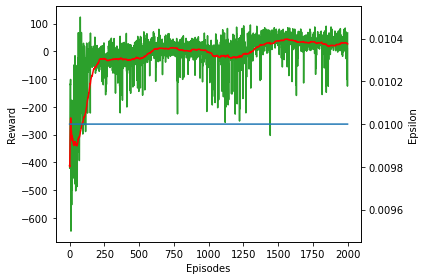

In [8]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward')
ax1.plot(df.iloc[:,0], df.iloc[:,2:3], color=color)
ax1.plot(df.iloc[:,0], df.iloc[:,3:4], color='red')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Epsilon')  # we already handled the x-label with ax1
ax2.plot(df.iloc[:,0], df.iloc[:,1:2], color=color)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()